In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/the-movies-dataset/ratings.csv
/kaggle/input/the-movies-dataset/links_small.csv
/kaggle/input/the-movies-dataset/credits.csv
/kaggle/input/the-movies-dataset/keywords.csv
/kaggle/input/the-movies-dataset/movies_metadata.csv
/kaggle/input/the-movies-dataset/ratings_small.csv
/kaggle/input/the-movies-dataset/links.csv
/kaggle/input/tmdb-movie-metadata/tmdb_5000_movies.csv
/kaggle/input/tmdb-movie-metadata/tmdb_5000_credits.csv


Hey there! Today we will go about creating a movie recommendation system using data from the TMDB dataset. We'll make different types of recommendation systems such as a user based, demographic based, etc.  
Lets start off with reading our dataset!

In [2]:
df1=pd.read_csv("/kaggle/input/tmdb-movie-metadata/tmdb_5000_credits.csv")
df2=pd.read_csv("/kaggle/input/tmdb-movie-metadata/tmdb_5000_movies.csv")

We'll go ahead and merge them into a single dataframe...

In [3]:
df1.columns = ['id','title','cast','crew']
df2= df2.merge(df1,on='id')


We've a lot of columns to play around with, so lets look at all of them and make educated decisions for our models. We'll firstly begin with the demographic based sysetm, and then move onto more complex ones!

In [4]:
df2.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title_x', 'vote_average',
       'vote_count', 'title_y', 'cast', 'crew'],
      dtype='object')

# Demographic Filtering  
Demographic filtering is a method used in movie recommendation systems to suggest movies to users based on their demographic characteristics, such as age, gender, and occupation. The system takes into account the demographic profiles of users and the demographic profiles of movies to match movies to users who have similar demographic characteristics.

For example, if the recommendation system knows that a user is a young female, it might suggest romantic comedies or chick flicks that are more likely to appeal to that demographic. On the other hand, if the user is a middle-aged male, the system might suggest action or adventure movies.

In order to make sense of our data, we will use IMDB's wieghted ratings in order to make it fair and even...

In [5]:
C= df2['vote_average'].mean()
C

6.092171559442016

In [6]:
m= df2['vote_count'].quantile(0.9)
m

1838.4000000000015

In [7]:
q_movies = df2.copy().loc[df2['vote_count'] >= m]
q_movies.shape

(481, 23)

In [8]:
def weighted_rating(x,m=m,C=C):
    v=x['vote_count']
    R=x['vote_average']
    
    return (v/(v+m)*R)+ (m/(m+v)*C)

In [9]:
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

In [10]:
q_movies=q_movies.sort_values(by='score',ascending=False)
q_movies.head(10)[['title_y', 'vote_count', 'vote_average', 'score']]

,title_y,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.059258
662,Fight Club,9413,8.3,7.939256
65,The Dark Knight,12002,8.2,7.920020
3232,Pulp Fiction,8428,8.3,7.904645
96,Inception,13752,8.1,7.863239
3337,The Godfather,5893,8.4,7.851236
95,Interstellar,10867,8.1,7.809479
809,Forrest Gump,7927,8.2,7.803188
329,The Lord of the Rings: The Return of the King,8064,8.1,7.727243
1990,The Empire Strikes Back,5879,8.2,7.697884


On a similair note, we can go ahead and make use of the popularity column to suggest popularity metrics and recommend movies based on that.

Text(0.5, 1.0, 'Popular Movies')

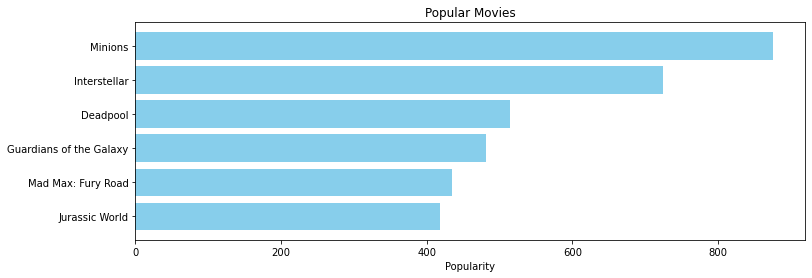

In [11]:
pop= df2.sort_values('popularity', ascending=False)
plt.figure(figsize=(12,4))

plt.barh(pop['title_y'].head(6),pop['popularity'].head(6), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

In [12]:
df2['overview'].head(5)

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
3    Following the death of District Attorney Harve...
4    John Carter is a war-weary, former military ca...
Name: overview, dtype: object

However our model here is not very personalized, and generates a common list of movies that is not unique to anyone and is very generic. We'll go ahead with a conten based filtering method to better optimize our recommendations.

# Content Based Filtering  
Content-based filtering is a method used in movie recommendation systems to suggest movies to users based on the content of the movies and the preferences of the users. The system analyzes the content of the movies, such as their genre, actors, directors, and keywords, and uses this information to determine which movies are similar to each other.

For example, if a user has watched and liked several action movies, the recommendation system might suggest other action movies that have similar content, such as similar actors, directors, or genre. The system takes into account the user's viewing history and preferences and suggests movies that are most similar to the movies the user has liked in the past.




Scikit fortunately provides a beautiful method that lets us make our tfidf matrix.

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf=TfidfVectorizer(stop_words='english')

df2['overview']=df2['overview'].fillna('')

tfidf_matrix=tfidf.fit_transform(df2['overview'])


tfidf_matrix.shape

(4803, 20978)

TF-IDF stands for Term Frequency-Inverse Document Frequency. It's a numerical statistic used to evaluate how important a word is to a document within a collection of documents (such as a corpus). The term frequency (TF) is the number of times a word appears in a document, while the inverse document frequency (IDF) is a measure of how rare the word is across the entire collection of documents.

The TF-IDF value for a word is calculated by multiplying its term frequency in a document by its inverse document frequency across the entire collection of documents. Words that are common in a document but rare in the collection of documents will have a high TF-IDF value, while words that are common in both the document and the collection of documents will have a low TF-IDF value.

Now how do we find similairty for each of these terms in our tf idf? We go ahead with cosine similarityy to get the commonality and recommend movies based on the most similair content.

In [14]:
from sklearn.metrics.pairwise import linear_kernel

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

cosine_sim.shape

(4803, 4803)

In [15]:
indices=pd.Series(df2.index,index=df2['title_y']).drop_duplicates()
indices.iloc[3]

3

The following function below performs the tasks:  
1.Get movie by index  
2.Get all similairty index with the movie  
3.Retrieve top 10 most similair movie from this cosine matrix

In [16]:
def get_recommendations(title, cosine_sim=cosine_sim):
    #Get index given the title
    idx=indices[title]
    
    #Get similarty score of all movies with that movie
    sim_scores=list(enumerate(cosine_sim[idx]))
    
    
    sim_scores = sorted(sim_scores,key=lambda x: x[1],reverse=True)
    
    sim_scores = sim_scores[1:11]
   
    movie_indices = [i[0] for i in sim_scores]
    
    return df2['title_y'].iloc[movie_indices]

Lets try our system out!

In [17]:
get_recommendations('The Dark Knight Rises')

65                              The Dark Knight
299                              Batman Forever
428                              Batman Returns
1359                                     Batman
3854    Batman: The Dark Knight Returns, Part 2
119                               Batman Begins
2507                                  Slow Burn
9            Batman v Superman: Dawn of Justice
1181                                        JFK
210                              Batman & Robin
Name: title_y, dtype: object

Works well! However, it would be better if we could make use of a bit more features such as cast, etc. Lets go ahead and do that now.

In [18]:
# Parse the stringified features into their corresponding python objects
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    df2[feature] = df2[feature].apply(literal_eval)

In [19]:
# Get the director's name from the crew feature. If director is not listed, return NaN
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [20]:
# Returns the list top 3 elements or entire list; whichever is more.
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

In [21]:
df2['director'] = df2['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    df2[feature] = df2[feature].apply(get_list)

In [22]:
df2[['title_y', 'cast', 'director', 'keywords', 'genres']].head(3)

,title_y,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"


In [23]:
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [24]:
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    df2[feature] = df2[feature].apply(clean_data)

Using all these features,  we will make our word soup which has all the important features and make the cosine similairt matrix again for all the movies

In [25]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
df2['soup'] = df2.apply(create_soup, axis=1)

Notice how we'll use countvectorizer and not tf-idf, since we dont want lesser used terms to be weighted, since that makes no sense!

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df2['soup'])

In [27]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [28]:
df2 = df2.reset_index()
indices = pd.Series(df2.index, index=df2['title_y'])

In [29]:
get_recommendations('The Dark Knight Rises', cosine_sim2)

65               The Dark Knight
119                Batman Begins
4638    Amidst the Devil's Wings
1196                The Prestige
3073           Romeo Is Bleeding
3326              Black November
1503                      Takers
1986                      Faster
303                     Catwoman
747               Gangster Squad
Name: title_y, dtype: object

This works extremely well! Good job! However we still have a major drawback in the sense that our system does not recommend new content and sticsk to similair content that is already knowm. So how do we go about recommending newer content to our user? One way is through user collaboration  method.  
Collaborative filtering is a method used in movie recommendation systems to suggest movies to users based on the preferences and behaviors of other users. The system does not analyze the content of the movies, but instead focuses on the relationships between users and movies.  
We use the surprise library to read a new dataset that has userids and create a recommendation system centered around the user.

In [30]:
ids=pd.read_csv('../input/the-movies-dataset/links_small.csv')
ids

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
9120,162672,3859980,402672.0
9121,163056,4262980,315011.0
9122,163949,2531318,391698.0
9123,164977,27660,137608.0


In [31]:
from surprise import Reader, Dataset, SVD
reader = Reader()
ratings = pd.read_csv('../input/the-movies-dataset/ratings_small.csv')
ratings.shape

(100004, 4)

In order to make this model, we will use SVD. 
SVD stands for Singular Value Decomposition, which is a mathematical technique that is commonly used in tasks such as our movie recommendation systems. Imagine you have a giant spreadsheet with a list of all the movies that people have watched and rated. SVD is a way to take that giant spreadsheet and simplify it into something more manageable.

The idea is to represent each movie and each person as a vector, with each entry in the vector representing the rating of a particular movie by a particular person. Using SVD, we can find new vectors that describe both the movies and the people in a way that makes it easy to make recommendations.

The key insight of SVD is that not all of the information in the spreadsheet is equally important. Some movies are rated more highly by many people, while others are only liked by a few. Some people rate a lot of movies, while others only rate a few. SVD takes all of this into account and finds the most important information, then uses that information to make recommendations.

In [32]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
svd = SVD()

In [33]:
from surprise.model_selection import cross_validate
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8942  0.9006  0.9028  0.8906  0.8957  0.8968  0.0044  
MAE (testset)     0.6906  0.6925  0.6948  0.6850  0.6881  0.6902  0.0034  
Fit time          6.45    6.28    6.13    6.11    6.25    6.24    0.12    
Test time         0.17    0.17    0.34    0.16    0.20    0.21    0.07    


{'test_rmse': array([0.89424891, 0.90064151, 0.90275985, 0.89055824, 0.89573448]),
 'test_mae': array([0.69058602, 0.6925344 , 0.69477428, 0.68499648, 0.68812467]),
 'fit_time': (6.4469895362854,
  6.283807992935181,
  6.134940147399902,
  6.109995603561401,
  6.247720241546631),
 'test_time': (0.1746964454650879,
  0.1654524803161621,
  0.33745789527893066,
  0.16065096855163574,
  0.2020871639251709)}

In [34]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [35]:
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


Lets try to see a prediction for our userid 1 and see what we get for a movie with index 302...

In [36]:
svd.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=2.81023513793083, details={'was_impossible': False})

Interesting! It predicts around 2.7 which is a relatively average score for a movie. Notice how SVD does not require us to use the movie details. It is not considered with any details of the movie at all.  
We've made all our different models and identified each ones strengths as well.
Thats all for todays notebook, have a great day ahead!

In [37]:
import joblib
joblib.dump(svd, 'svdmodel.pkl')

['svdmodel.pkl']

In [38]:
loaded_model = joblib.load('svdmodel.pkl')

In [39]:
loaded_model.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=2.81023513793083, details={'was_impossible': False})